# Практика застосування kNN та Naive Bayes. EDA

### Знайомство з даними

In [1]:
import warnings
import pandas as pd
import numpy as np
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../datasets/mod_04_topic_07_bank_data.csv', sep=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
data.drop('duration', axis=1, inplace=True)

### Розподіл ознак

In [4]:
data.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [5]:
data.skew(numeric_only=True)

age               0.784697
campaign          4.762507
pdays            -4.922190
previous          3.832042
emp.var.rate     -0.724096
cons.price.idx   -0.230888
cons.conf.idx     0.303180
euribor3m        -0.709188
nr.employed      -1.044262
dtype: float64

# Практика застосування kNN та Naive Bayes. Підготовка й обробка даних

### Вимоги алгоритмів до обробки даних
### Очистка від викидів

In [6]:
data = data[np.abs(zscore(data['campaign'])) < 2]

### Видалення ознак, тісно пов`язаних з іншими ознаками

<Axes: >

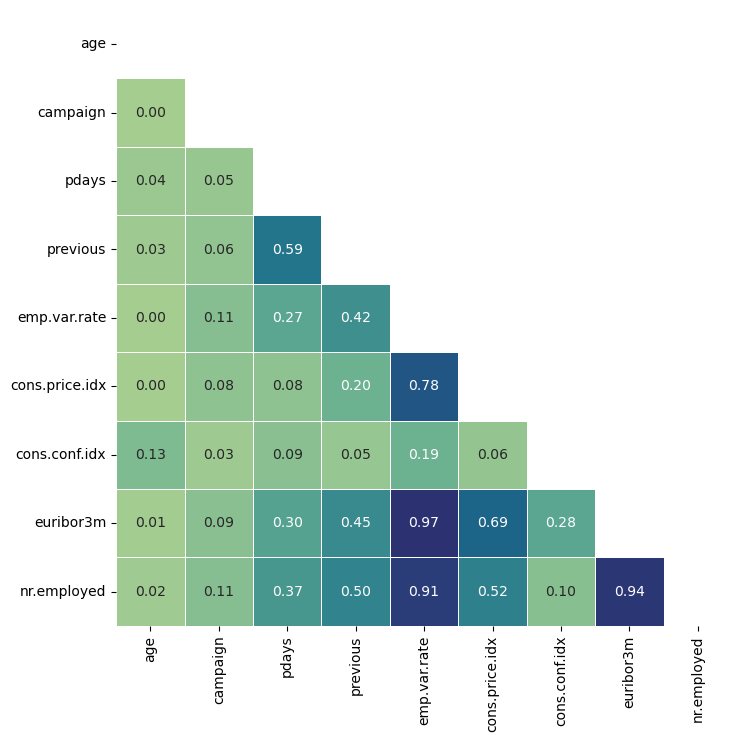

In [7]:
mtx = data.drop('y', axis=1).corr(numeric_only=True).abs()

fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(mtx,
            cmap='crest',
            annot=True,
            fmt=".2f",
            linewidth=.5,
            mask=np.triu(np.ones_like(mtx, dtype=bool)),
            square=True,
            cbar=False,
            ax=ax)

In [8]:
data.drop(
    ['emp.var.rate',
     'cons.price.idx',
     'nr.employed'],
    axis=1,
    inplace=True)

### Огляд категоріальних ознак

In [9]:
data.select_dtypes(include='object').nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
y               2
dtype: int64

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    data['y'] = data['y'].replace({'no': 0, 'yes': 1})

### Розбиття на тренувальну і тестову вибірки

In [11]:
X_train, X_test, y_train, y_test = (
    train_test_split(
        data.drop('y', axis=1),
        data['y'],
        test_size=0.2,
        random_state=42))

### Кодування категоріальних змінних

In [12]:
cat_cols = X_train.select_dtypes(include='object').columns
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [13]:
encoder = ce.WOEEncoder(cols=cat_cols)

X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

### Нормалізація змінних. Зменшення асиметрії

In [14]:
power_transform = PowerTransformer().set_output(transform='pandas')

X_train = power_transform.fit_transform(X_train)
X_test = power_transform.transform(X_test)

In [15]:
X_train.skew()

age              0.007984
job              0.048212
marital          0.826785
education        0.056809
default          2.514470
housing         -0.106005
loan            -1.703180
contact         -0.586952
month            0.104885
day_of_week     -0.179013
campaign         0.237176
pdays           -4.813348
previous         2.069751
poutcome         2.070238
cons.conf.idx    0.049700
euribor3m       -0.615990
dtype: float64

### Балансування класів

In [16]:
y_train.value_counts(normalize=True)

y
0    0.884514
1    0.115486
Name: proportion, dtype: float64

In [17]:
sm = SMOTE(random_state=42, k_neighbors=50)
X_res, y_res = sm.fit_resample(X_train, y_train)

D:\install\miniconda3\envs\env_mlf\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\install\miniconda3\envs\env_mlf\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\install\miniconda3\envs\env_mlf\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\install\miniconda3\envs\env_mlf\Lib\site-packages\spyder_kernels\customize\spydercustomize.py", line 47, in __init__
    super(SubprocessPopen, self).__init__(*args, **kwargs)
  File "D:\install\miniconda3\envs\env_mlf\Lib

# Практика застосування kNN та Naive Bayes. Побудова й оцінка моделей

### kNN-класифікатор

In [18]:
knn_mod = KNeighborsClassifier(n_neighbors=7, n_jobs=-1).fit(X_res, y_res)

knn_preds = knn_mod.predict(X_test)

knn_score = balanced_accuracy_score(y_test, knn_preds)

print(f'KNN model accuracy: {knn_score:.1%}')

KNN model accuracy: 69.8%


### Naive Bayes класифікатор

In [19]:
gnb_mod = GaussianNB().fit(X_res, y_res)

gnb_preds = gnb_mod.predict(X_test)

gnb_score = balanced_accuracy_score(y_test, gnb_preds)

print(f'GNB model accuracy: {gnb_score:.1%}')

GNB model accuracy: 70.9%


In [20]:
confusion_matrix(y_test, gnb_preds)

array([[5934, 1123],
       [ 384,  522]])